# Multiclass Classification on Image Data

### Re-implementation from [Daniel Bourke](https://www.learnpytorch.io/03_pytorch_computer_vision/#1-getting-a-dataset)

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchmetrics
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import functools
from timeit import default_timer as timer

RANDOM_SEED = 100  # for reproducibility

## Assemble Data

In [2]:
# fetch Fastion MNIST data
train_data = datasets.FashionMNIST(
    root="./",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="./",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
print(f"train n = {len(train_data)}")
print(f"test n = {len(test_data)}fd")
NUM_CLASSES = len(train_data.classes)
print(f"n classes = {NUM_CLASSES}")
image_shape = train_data[0][0].shape
print(f"image dim = {image_shape}")
NUM_FEATURES = functools.reduce(lambda a, b: a * b, image_shape)
print(f"n features = {NUM_FEATURES}")

train n = 60000
test n = 10000fd
n classes = 10
image dim = torch.Size([1, 28, 28])
n features = 784


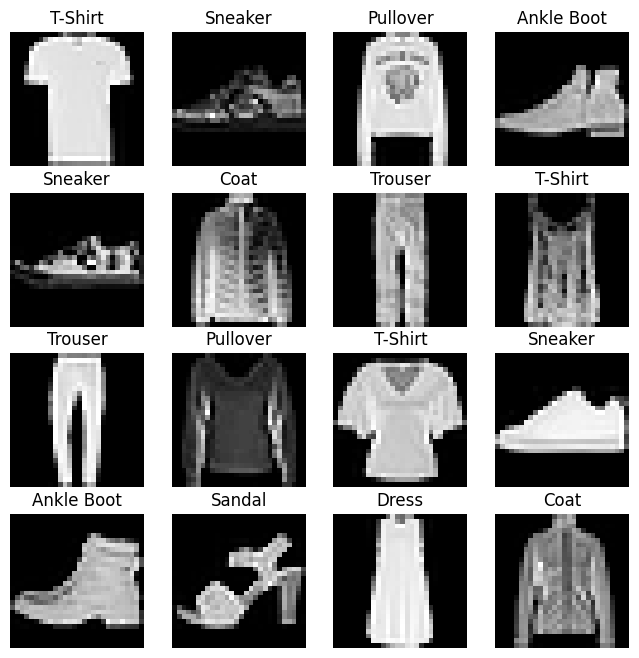

In [4]:
# visualize classes
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4

torch.manual_seed(RANDOM_SEED)

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
# convert type dataset to type dataloader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [6]:
sample_batch_x, sample_batch_y = next(iter(train_dataloader))

print(sample_batch_x.shape)
print(sample_batch_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Functionalize Training and Dev steps

In [7]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device
              ):
    """performs one training iteration with a batch"""
    train_loss, train_accuracy = 0, 0
    
    for batch, (X_train, y_train) in enumerate(dataloader):
        # training mode
        model.train()

        # forward pass
        y_logits = model(X_train.to(device))

        # calculate loss & accuracy
        loss = loss_fn(y_logits, y_train)
        train_loss += loss.detach().numpy()
        train_accuracy += accuracy_fn(y_logits, y_train).detach().numpy()

        # clear optimizer accumulation
        optim.zero_grad()

        # calculate gradients via backpropagation
        loss.backward()

        # update parameters
        optim.step()

    # average loss & accuracy across batch
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)
    
    print(f"Train loss: {train_loss:.5f}\
            Train Accuracy: {train_accuracy:.5f}")

    return train_loss, train_accuracy

def dev_step(model: nn.Module,
             dataloader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn,
             device: torch.device
            ):
    """performs one validation step with a batch"""
    dev_loss, dev_accuracy = 0,0
    
    for batch, (X_dev, y_dev) in enumerate(dataloader):
        # faster inferences, no autograd
        with torch.inference_mode():
            # forward pass
            y_logits = model(X_dev.to(device))

            # calculate loss & accuracy
            loss = loss_fn(y_logits, y_dev)
            dev_loss += loss.detach().numpy()
            dev_accuracy += accuracy_fn(y_logits, y_dev).detach().numpy()

    # average loss & accuracy across batch
    dev_loss /= len(dataloader)
    dev_accuracy /= len(dataloader)

    print(f"Dev loss: {dev_loss:.5f}\
            Dev Accuracy: {dev_accuracy:.5f}")

    return dev_loss, dev_accuracy

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Build Linear Model

In [9]:
class FashionMNISTClassifierV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        """Initializes all required hyperparameters for model"""
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.layers(x)

In [10]:
model_0 = FashionMNISTClassifierV0(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)

In [11]:
model_0.parameters

<bound method Module.parameters of FashionMNISTClassifierV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=10, bias=True)
  )
)>

## Train Linear Model

In [12]:
# create a loss function
loss_fn = nn.CrossEntropyLoss() 

# optimizer will update parameters with gradients calculated from backpropagation
# optim = torch.optim.SGD(params=model.parameters(), lr=0.01)
optim = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [13]:
torch.manual_seed(RANDOM_SEED)

accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES)

epochs = 10

# for tracking learning
train_loss_values = []
train_accuracy_values = []
dev_loss_values = []
dev_accuracy_values = []
start_time = timer()

# ----------- train loop -----------
for epoch in range(epochs):
    print(f"-------Epoch: {epoch}-------")
    train_loss, train_accuracy = \
        train_step(model_0, train_dataloader, loss_fn, accuracy_fn, device)
    train_loss_values += [train_loss]
    train_accuracy_values += [train_accuracy]
    
    dev_loss, dev_accuracy = \
        dev_step(model_0, test_dataloader, loss_fn, accuracy_fn, device)
    dev_loss_values += [dev_loss]
    dev_accuracy_values += [dev_accuracy]
    
end_time = timer()
print(f"-------Epoch: {epoch}-------\nTotal training time: {end_time - start_time:.3f}s")

-------Epoch: 0-------
Train loss: 1.05884            Train Accuracy: 0.66633
Dev loss: 0.75851            Dev Accuracy: 0.73288
-------Epoch: 1-------
Train loss: 0.67685            Train Accuracy: 0.76046
Dev loss: 0.64520            Dev Accuracy: 0.76851
-------Epoch: 2-------
Train loss: 0.59525            Train Accuracy: 0.79134
Dev loss: 0.58972            Dev Accuracy: 0.79180
-------Epoch: 3-------
Train loss: 0.55104            Train Accuracy: 0.80847
Dev loss: 0.55770            Dev Accuracy: 0.80484
-------Epoch: 4-------
Train loss: 0.52265            Train Accuracy: 0.81890
Dev loss: 0.53703            Dev Accuracy: 0.81180
-------Epoch: 5-------
Train loss: 0.50304            Train Accuracy: 0.82488
Dev loss: 0.52698            Dev Accuracy: 0.81419
-------Epoch: 6-------
Train loss: 0.48831            Train Accuracy: 0.82962
Dev loss: 0.51399            Dev Accuracy: 0.81897
-------Epoch: 7-------
Train loss: 0.47679            Train Accuracy: 0.83484
Dev loss: 0.50091  

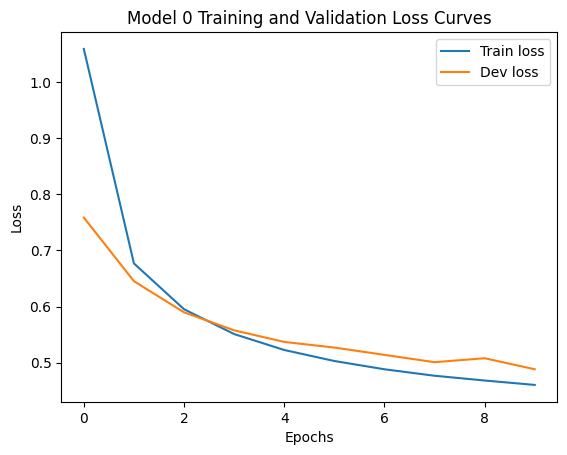

In [14]:
# plot loss curves
plt.plot(torch.arange(epochs), train_loss_values, label="Train loss")
plt.plot(torch.arange(epochs), dev_loss_values, label="Dev loss")
plt.title("Model 0 Training and Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Model 0 started overfitting after epoch 2 when accuracy was around 0.792

## Build CNN Model

In [15]:
class FashionMNISTClassifierV1(nn.Module):
    # TinyVGG from https://poloclub.github.io/cnn-explainer/
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        """Initializes all required hyperparameters for model"""
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
        
    def forward(self, x):
        y = self.conv_block_1(x)
        y = self.conv_block_2(y)
#         return self.classifier(self.conv_block(self.conv_block(x)))
        return self.classifier(y)

In [16]:
model_1 = FashionMNISTClassifierV1(input_shape=1, output_shape=NUM_CLASSES, hidden_units=10).to(device)

In [17]:
model_1.parameters

<bound method Module.parameters of FashionMNISTClassifierV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)>

## Train CNN Model

In [18]:
# create a loss function
loss_fn = nn.CrossEntropyLoss() 

# optimizer will update parameters with gradients calculated from backpropagation
# optim = torch.optim.SGD(params=model.parameters(), lr=0.01)
optim = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [19]:
torch.manual_seed(RANDOM_SEED)

accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES)

epochs = 10

# for tracking learning
train_loss_values = []
train_accuracy_values = []
dev_loss_values = []
dev_accuracy_values = []
start_time = timer()

# ----------- train loop -----------
for epoch in range(epochs):
    print(f"-------Epoch: {epoch}-------")
    train_loss, train_accuracy = \
        train_step(model_1, train_dataloader, loss_fn, accuracy_fn, device)
    train_loss_values += [train_loss]
    train_accuracy_values += [train_accuracy]
    
    dev_loss, dev_accuracy = \
        dev_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)
    dev_loss_values += [dev_loss]
    dev_accuracy_values += [dev_accuracy]
    
end_time = timer()
print(f"-------Epoch: {epoch}-------\nTotal training time: {end_time - start_time:.3f}s")

-------Epoch: 0-------
Train loss: 1.89186            Train Accuracy: 0.32126
Dev loss: 1.32116            Dev Accuracy: 0.62082
-------Epoch: 1-------
Train loss: 0.70692            Train Accuracy: 0.74783
Dev loss: 0.69605            Dev Accuracy: 0.74144
-------Epoch: 2-------
Train loss: 0.56366            Train Accuracy: 0.79812
Dev loss: 0.57298            Dev Accuracy: 0.79070
-------Epoch: 3-------
Train loss: 0.49277            Train Accuracy: 0.82434
Dev loss: 0.51385            Dev Accuracy: 0.81688
-------Epoch: 4-------
Train loss: 0.44914            Train Accuracy: 0.84095
Dev loss: 0.53116            Dev Accuracy: 0.79817
-------Epoch: 5-------
Train loss: 0.42082            Train Accuracy: 0.85145
Dev loss: 0.44432            Dev Accuracy: 0.84644
-------Epoch: 6-------
Train loss: 0.39968            Train Accuracy: 0.85876
Dev loss: 0.42933            Dev Accuracy: 0.84803
-------Epoch: 7-------
Train loss: 0.38523            Train Accuracy: 0.86431
Dev loss: 0.39676  

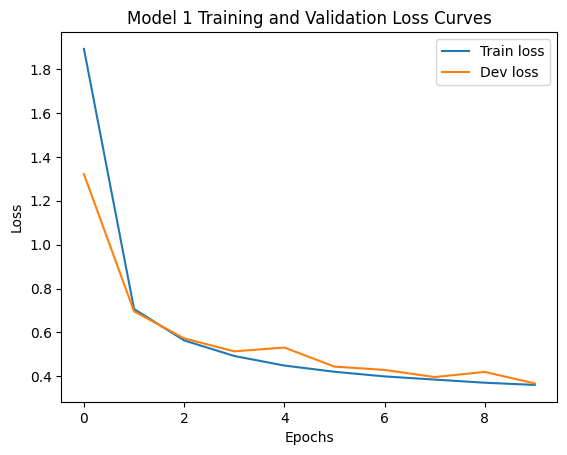

In [20]:
# plot loss curves
plt.plot(torch.arange(epochs), train_loss_values, label="Train loss")
plt.plot(torch.arange(epochs), dev_loss_values, label="Dev loss")
plt.title("Model 1 Training and Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Model 1 was slightly more accuracte than model 0!